In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.special import gamma as gamma_function
from numpy.fft import rfft, irfft
import time

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12
})

In [9]:
def bsm_price(S, K, T, r, q, sigma, flag):
    """
    Calculates the Black-Scholes-Merton option price.

    Parameters:
    ----------
    S: Underlying asset price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate
    q: Continuous dividend yield
    sigma: Volatility
    flag: Option type ('c' for call, 'p' for put)

    Returns:
    -------
    float
        The calculated price of the option.
    """
    # Handle edge cases with zero/near-zero time to maturity or volatility by returning intrinsic value.
    if T <= 1e-6 or sigma <= 1e-6:
        return np.maximum(0, S * np.exp(-q * T) - K * np.exp(-r * T)) if flag == 'c' else np.maximum(0, K * np.exp(-r * T) - S * np.exp(-q * T))
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if flag == 'c':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def find_implied_vol(target_price, S, K, T, r, q, flag):
    """
    Calculates the implied volatility for an option.
    This is the volatility that makes the BSM price equal to the market price.

    Parameters:
    ----------
    price: Market price of the option
    S, K, T, r, q, flag: BSM model parameters

    Returns:
    -------
    float
        The implied volatility, or np.nan if not found.
    """
    # The objective is to find the root of: BSM_price(sigma) - target_price = 0
    objective = lambda sigma: bsm_price(S, K, T, r, q, sigma, flag) - target_price
    
    try:
        # Use a numerical solver (Brent's method) to find the root for sigma
        # within a reasonable search range (e.g., 0.01% to 500%).
        return brentq(objective, 1e-4, 5.0)
    except (ValueError, RuntimeError): # If no root is found, return NaN
        return np.nan

class rBergomi:
    """
    A fully vectorized rBergomi simulation engine using the Hybrid Scheme.
    """
    def __init__(self, n_steps=252, T=1.0, H=0.10):
        self.T = float(T)
        self.H = float(H)
        # Alpha is the exponent in the Riemann-Liouville fractional Brownian motion kernel (t-s)^(H-1/2)
        self.alpha = self.H - 0.5
        self.n_steps = int(n_steps)
        self.dt = self.T / self.n_steps
        self.time_grid = np.linspace(0, T, self.n_steps + 1)
        
        # Covariance matrix for the bivariate normal vector [W1, W2] used in the Hybrid Scheme.
        var_W1 = self.dt
        var_W2 = (self.dt**(2 * self.H)) / (2 * self.H)
        cov_W1_W2 = (self.dt**(self.H + 0.5)) / (self.H + 0.5)
        self.cov_matrix = np.array([[var_W1, cov_W1_W2], [cov_W1_W2, var_W2]])

        # Pre-compute the gamma_k coefficients for the convolution in the Hybrid Scheme.
        # This relates to the approximation of the kernel function for the "far" part of the integral.
        k = np.arange(2, self.n_steps + 1)
        b_k = ((k**(self.alpha + 1) - (k - 1)**(self.alpha + 1)) / (self.alpha + 1))**(1 / self.alpha)
        self.gamma_k = (b_k * self.dt)**self.alpha

    def generate_paths(self, N_paths, rho, eta, xi, S0, r, q):
        """Generates all asset price paths in a single vectorized operation."""
        # Generate correlated Brownian motion increments for the Hybrid Scheme
        dW_vectors = np.random.multivariate_normal(
            mean=[0, 0], cov=self.cov_matrix, size=(N_paths, self.n_steps)
        )
        W1_increments = dW_vectors[:, :, 0] # Drives both volatility and price
        W2_increments = dW_vectors[:, :, 1] # "Near" part of the volatility integral
        
        # Generate the orthogonal component of the asset's Brownian motion
        dW_perp = np.random.randn(N_paths, self.n_steps) * np.sqrt(self.dt)

        # Simulate the Riemann-Liouville process Y, which is a Truncated Brownian Semi-Stationary (TBSS) process.
        Y = np.zeros((N_paths, self.n_steps + 1))

        # Pad the kernel `gamma_k` with a leading zero to match the signal's length.
        # Original `self.gamma_k` has length (n_steps - 1).
        gamma_k_padded = np.zeros(self.n_steps)
        # Place the original coefficients from the second element onwards.
        gamma_k_padded[1:] = self.gamma_k
        
        # 2. Set the FFT length to 2*n for a standard, robust convolution.
        fft_len = 2 * self.n_steps

        # 3. Perform the FFT on arrays of the same size. This operation is now numerically stable.
        gamma_k_fft = rfft(gamma_k_padded, fft_len)
        W1_fft = rfft(W1_increments, fft_len, axis=1)
        
        # 4. Multiply in the Fourier domain and then transform back.
        convolution_sum = irfft(gamma_k_fft * W1_fft, fft_len, axis=1)[:, :self.n_steps]
        
        Y[:, 1:] = np.sqrt(2 * self.H) * (W2_increments + convolution_sum)
        
        # Simulate the variance process V(t) where V is the forward variance (xi)
        # multiplied by the Wick exponential of the process Y. The variance of (eta * Y_t) is (eta^2 * t^(2H)).
        V = xi * np.exp(eta * Y - 0.5 * eta**2 * self.time_grid**(2 * self.H))
        
        # Simulate the asset price process S(t) using an Euler scheme on the log-price.
        S = np.zeros((N_paths, self.n_steps + 1))
        S[:, 0] = S0
        V_sliced = np.maximum(V[:, :-1], 1e-12) # Use variance from the start of the interval, avoid sqrt(0)
        
        # Construct the correlated Brownian motion dB for the asset price
        dB = rho * W1_increments + np.sqrt(1 - rho**2) * dW_perp
        
        log_increments = (r - q - 0.5 * V_sliced) * self.dt + np.sqrt(V_sliced) * dB
        log_S_paths = np.log(S0) + np.cumsum(log_increments, axis=1)
        S[:, 1:] = np.exp(log_S_paths)
        
        return S

def _simulate_hybrid_components(H, n_steps, T):
    """
    Generates the core components for the Hybrid Scheme: the Riemann-Liouville process (Y)
    and its underlying Brownian motion increments (W1). This implementation is based on
    the method described in the thesis (Chapter 8.2.2).
    """
    # --- Step 1: Calculate Core Parameters ---
    dt = T / n_steps
    alpha = H - 0.5
    n_steps_per_year = int(n_steps / T) if T > 0 else n_steps

    # --- Step 2: Construct the Covariance Matrix for the Hybrid Scheme ---
    # This matrix is essential for generating the two correlated components of the scheme.
    var_W1 = dt
    var_W2 = dt**(2 * H) / (2 * H)
    cov_W1_W2 = dt**(H + 0.5) / (H + 0.5)
    cov_matrix = np.array([[var_W1, cov_W1_W2],
                           [cov_W1_W2,  var_W2]])

    # --- Step 3: Generate the Required Random Variates ---
    random_vectors = np.random.multivariate_normal([0, 0], cov_matrix, n_steps)
    W1_increments = random_vectors[:, 0]  # For the memory (convolution) and the price process.
    W2_increments = random_vectors[:, 1]  # For the instantaneous shock (singularity).
    
    # --- Step 4: The Convolution (Memory Term) ---
    # This part approximates the integral with a memory kernel.
    k = np.arange(2, n_steps + 1)
    # Calculate the optimal b_k* weights as per.
    base = (k**(alpha + 1) - (k - 1)**(alpha + 1)) / (alpha + 1)
    b_k_star = np.abs(base)**(1 / alpha)
    
    convolution_coeffs = (b_k_star / n_steps_per_year)**alpha
    # Perform the discrete convolution using numpy.
    convolution_sum = np.convolve(convolution_coeffs, W1_increments, mode='full')[:n_steps]

    # --- Step 5: Assemble the Riemann-Liouville Process ---
    # Combine the singularity and memory terms to form the process Y.
    Y = np.zeros(n_steps + 1)
    Y[1:] = np.sqrt(2 * H) * (W2_increments + convolution_sum)
    
    return Y, W1_increments

def simulate_rbergomi_path(H, rho, eta, xi, S0, T, n_steps):
    """
    Simulates a single price and volatility path for the rBergomi model.
    """
    # Step 1: Generate the Riemann-Liouville process and its core random shocks.
    Y_path, W1_increments = _simulate_hybrid_components(H, n_steps, T)
    
    # Step 2: Construct the variance process using the exponential form.
    dt = T / n_steps
    time_grid = np.linspace(0, T, n_steps + 1)
    # This is the analytical solution for the variance process V_t.
    variance_path = xi * np.exp(eta * Y_path - 0.5 * eta**2 * time_grid**(2 * H))
    
    # Step 3: Construct the correlated stock price process.
    # Create an orthogonal Brownian motion that is uncorrelated with the volatility driver.
    dW_perp = np.sqrt(dt) * np.random.randn(n_steps)
    
    # Construct the correlated random increments (dB) that drive the stock price.
    dB = rho * W1_increments + np.sqrt(1 - rho**2) * dW_perp
    
    # Calculate the price path vectorially using the log-Euler scheme for stability.
    S_path = np.zeros(n_steps + 1)
    S_path[0] = S0
    
    # Prevent negative variance for numerical stability.
    V_t = np.maximum(variance_path[:-1], 1e-12)
    
    log_increments = -0.5 * V_t * dt + np.sqrt(V_t) * dB
    S_path[1:] = S0 * np.exp(np.cumsum(log_increments))
    
    # Return the instantaneous volatility (square root of variance).
    volatility_path = np.sqrt(variance_path)
    
    return time_grid, S_path, volatility_path
        
def generate_smile(H, rho, eta, xi, S0, T, n_steps, n_paths, moneyness):
    """Generates a single implied volatility smile for a given set of rBergomi parameters."""
    print(f"Starting simulation for H = {H:.2f}...")
    start_time = time.time()
    
    model = rBergomi(n_steps=n_steps, T=T, H=H)
    S_paths = model.generate_paths(n_paths, rho, eta, xi, S0, r=0.0, q=0.0)
    S_T = S_paths[:, -1] # Get the terminal stock prices
    
    implied_vols = []
    strike_range = moneyness * S0
    
    for K in strike_range:
        # Use Out-of-the-Money (OTM) options to reduce estimator noise.
        option_type = 'c' if K >= S0 else 'p'
        
        # Calculate the option price via Monte Carlo average of payoffs
        model_price = np.mean(np.maximum(S_T - K, 0) if option_type == 'c' else np.maximum(K - S_T, 0))
        
        # Back out the implied volatility from the model price
        iv = find_implied_vol(model_price, S0, K, T, r=0.0, q=0.0, flag=option_type)
        implied_vols.append(iv)
        
    print(f"Finished H = {H:.2f} in {(time.time() - start_time):.2f} seconds.")
    return implied_vols

def approximate_skew(H, tau, rho, eta, sigma_bar):
    """
    Calculates the approximate ATM forward skew according to equation.
    This function is vectorized to work even if H is a numpy array.
    """
    # Handle cases where H is near zero or invalid to avoid math errors.
    H = np.asfarray(H)
    result = np.full_like(H, np.nan, dtype=float)
    valid_mask = H > 0

    h_valid = H[valid_mask]

    # Helper terms D_H and E_H.
    D_H = np.sqrt(2 * h_valid) / (h_valid + 0.5)
    E_H = D_H / (h_valid + 1.5)

    # First main term of the equation.
    term1 = (rho * eta / 2.0) * E_H * (tau**(h_valid - 0.5))

    # Second main term of the equation.
    bracket_term_part1 = (D_H**2) / (1 + h_valid)
    bracket_term_part2 = 1 + (gamma_function(h_valid + 1.5)**2) / gamma_function(2 * h_valid + 3)
    bracket_term_part3 = (3.0 / 2.0) * (E_H**2)
    bracket = bracket_term_part1 * bracket_term_part2 - bracket_term_part3
    
    term2 = (1.0 / 4.0) * (rho**2) * (eta**2) * sigma_bar * (tau**(2 * h_valid)) * bracket

    result[valid_mask] = term1 + term2
    return result

def calculate_atm_forward_skew_structure(H, rho, eta, xi, S0, maturity_grid, n_paths_skew):
    """
    Calculates the term structure of the ATM forward skew for a given rBergomi parameter set.

    This function simulates the model at various maturities to estimate psi(tau), which is
    a key feature for model validation.
    The skew is calculated at each maturity point using numerical differentiation.
    """
    print(f"\nCalculating skew term structure for H = {H:.2f}...")
    skew_structure = []
    
    # Define a small step 'epsilon' for the finite difference calculation of the derivative.
    epsilon = 0.001 
    
    total_maturities = len(maturity_grid)
    # Iterate through each maturity T in the provided grid to build the term structure.
    for i, T in enumerate(maturity_grid):
        print(f"\r  -> Calculating maturity {i+1}/{total_maturities} (T={T:.2f} years)...", end="")
        
        n_steps = int(252 * T)
        if n_steps == 0: continue # Skip very short maturities that result in zero steps.
            
        # Initialize the rBergomi model for the current maturity T.
        model = rBergomi(n_steps=n_steps, T=T, H=H)
        
        # For each maturity, simulate the terminal asset price S_T using the rBergomi model.
        paths = model.generate_paths(n_paths_skew, rho, eta, xi, S0, r=0.0, q=0.0)
        S_T = paths[:, -1]
        
        # Define two strike prices slightly above and below the at-the-money (ATM) forward price
        # to approximate the derivative at that point. S0 is used as the ATM forward price.
        K_atm = S0
        K_up = K_atm * (1 + epsilon)
        K_down = K_atm * (1 - epsilon)
        
        # Price the two options (K_up and K_down) via Monte Carlo...
        price_up = np.mean(np.maximum(S_T - K_up, 0))
        # ...and then back out their respective implied volatilities.
        iv_up = find_implied_vol(price_up, S0, K_up, T, r=0.0, q=0.0, flag='c')
        
        price_down = np.mean(np.maximum(S_T - K_down, 0))
        iv_down = find_implied_vol(price_down, S0, K_down, T, r=0.0, q=0.0, flag='c')
        
        # Calculate the ATM forward skew using a central difference formula.
        # This approximates the derivative of implied volatility with respect to log-moneyness.
        # The use of abs() aligns with thesis, where psi(tau)
        # is defined as the absolute value of the skew.
        if iv_up is not None and iv_down is not None:
            # Numerical derivative: (change in implied vol) / (change in log-moneyness)
            log_moneyness_skew = abs((iv_up - iv_down) / (np.log(K_up / S0) - np.log(K_down / S0)))
            skew_structure.append(log_moneyness_skew)
        else:
            skew_structure.append(np.nan) # Append NaN if implied vol calculation fails
            
    print(f"\nCalculation finished for H = {H:.2f}.")
    return np.array(skew_structure)

## Simulated Rough Bergomi Path

Plot saved as 'rbergomi_path_simulation.png'


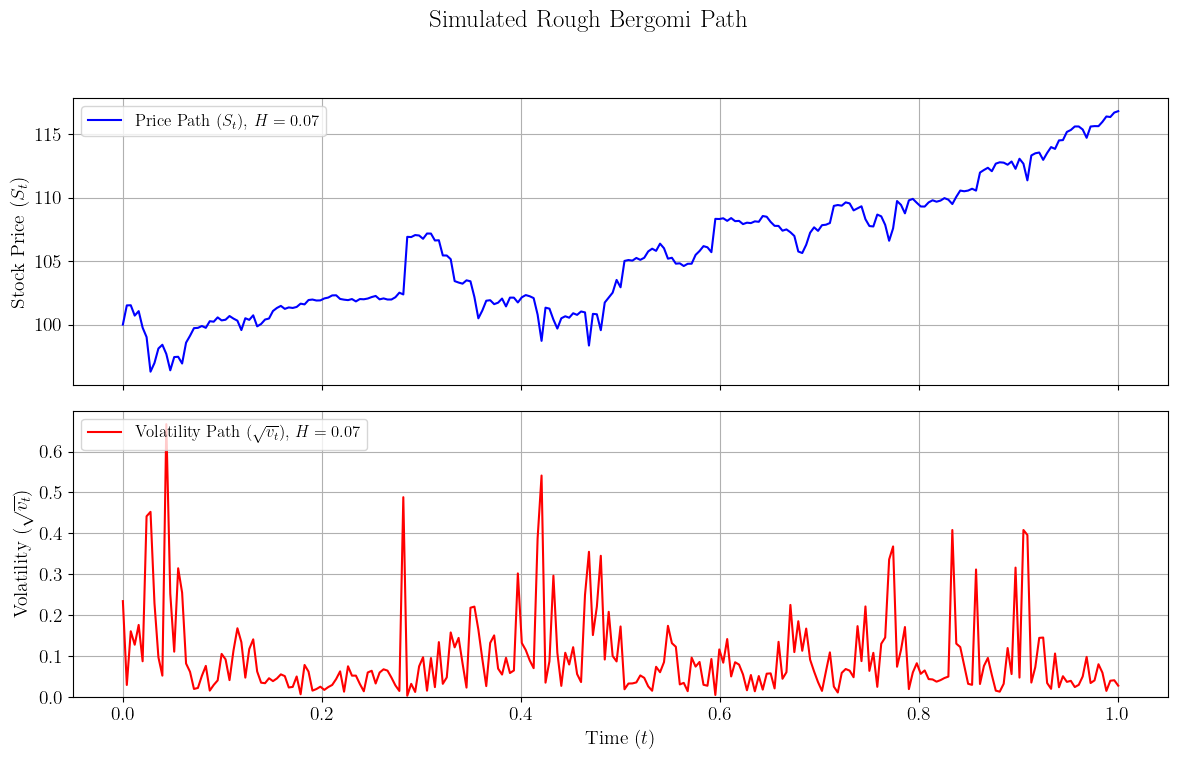

In [5]:
H_test = 0.07      # Hurst Parameter (for a 'rough' volatility path)
rho_test = -0.9    # Strong negative correlation between price and volatility
eta_test = 1.9     # Volatility of volatility
xi_test = 0.055    # Initial forward variance level (Note: this is variance, not vol)
S0_test = 100      # Initial stock price
T_test = 1.0       # Time horizon of 1 year
n_steps_test = 252 # Number of trading days in a year

# --- Run the Simulation ---
time_grid, price_path, volatility_path = simulate_rbergomi_path(
    H=H_test,
    rho=rho_test,
    eta=eta_test,
    xi=xi_test,
    S0=S0_test,
    T=T_test,
    n_steps=n_steps_test
)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
fig.suptitle(r'Simulated Rough Bergomi Path', fontsize=18)

# Price Path
price_label = fr'Price Path $(S_t)$, $H = {H_test}$'
ax[0].plot(time_grid, price_path, color='blue', label=price_label)
ax[0].set_ylabel(r'Stock Price $(S_t)$', fontsize=14)
ax[0].grid(True)
ax[0].legend(loc='upper left')

# Volatility Path
vol_label = fr'Volatility Path $(\sqrt{{v_t}})$, $H = {H_test}$'
ax[1].plot(time_grid, volatility_path, color='red', label=vol_label)
ax[1].set_ylabel(r'Volatility $(\sqrt{v_t})$', fontsize=14)
ax[1].set_xlabel(r'Time $(t)$', fontsize=14)
ax[1].grid(True)
ax[1].set_ylim(bottom=0)
ax[1].legend(loc='upper left')

# Adjust layout to prevent title overlap.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

plt.savefig('rbergomi_path_simulation.png', dpi=600)
print("Plot saved as 'rbergomi_path_simulation.png'")

plt.show()
plt.close(fig)


Dataset successfully loaded. Contains 25208 rows.
After filtering, 4394 rows remain.

Analysis Date: 25-07-2025
Spot Price (S): 6389.52
Assumption: Risk-Free Rate (r): 0.0
Assumption: Dividend Yield (q): 0.0
Data processing complete. Using 4289 points to build the surface.


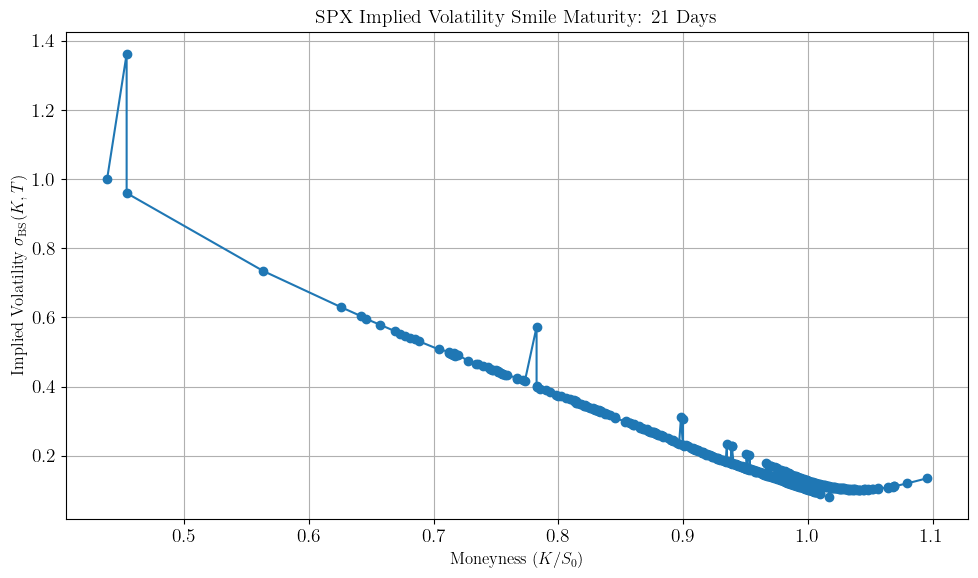

In [13]:
# --- Load Data ---

file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv'
df = pd.read_csv(file_path)
print(f"Dataset successfully loaded. Contains {len(df)} rows.")

# --- Filter and Clean Data ---
df_filtered = df[(df['bid_eod'] > 0) & (df['ask_eod'] > 0) & (df['trade_volume'] > 10)].copy()
df_filtered.reset_index(drop=True, inplace=True)
print(f"After filtering, {len(df_filtered)} rows remain.")

# --- Feature Engineering ---
df_filtered['quote_date'] = pd.to_datetime(df_filtered['quote_date'])
df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'])
df_filtered['time_to_maturity'] = ((df_filtered['expiration'] - df_filtered['quote_date']).dt.days) / 365.0
df_filtered['mid_price'] = (df_filtered['bid_eod'] + df_filtered['ask_eod']) / 2
clean_df = df_filtered[df_filtered['time_to_maturity'] > (2 / 365.0)].copy()

# --- Assign Market Values (r=0, q=0) ---
spot_price = (clean_df['underlying_bid_eod'].iloc[0] + clean_df['underlying_ask_eod'].iloc[0]) / 2
quote_date = clean_df['quote_date'].iloc[0]

risk_free_rate = 0.0
dividend_yield = 0.0
clean_df['risk_free_rate'] = risk_free_rate
clean_df['dividend_yield'] = dividend_yield

print(f"\nAnalysis Date: {quote_date.strftime('%d-%m-%Y')}")
print(f"Spot Price (S): {spot_price:.2f}")
print(f"Assumption: Risk-Free Rate (r): {risk_free_rate}")
print(f"Assumption: Dividend Yield (q): {dividend_yield}")

# --- Calculate Implied Volatility (with r=0, q=0) ---
clean_df = clean_df[clean_df['mid_price'] > 0]
# Arbitrage filter (with r=0, q=0 assumption)
intrinsic_value = np.where(
    clean_df['option_type'] == 'C',
    np.maximum(0, spot_price - clean_df['strike']), # Simplified form
    np.maximum(0, clean_df['strike'] - spot_price)  # Simplified form
)
clean_df = clean_df[clean_df['mid_price'] >= intrinsic_value]

clean_df['implied_vol'] = clean_df.apply(
    lambda row: find_implied_vol(
        target_price=row['mid_price'], S=spot_price, K=row['strike'], T=row['time_to_maturity'],
        r=risk_free_rate, q=dividend_yield, flag=row['option_type'].lower()
    ), axis=1
)
final_surface_df = clean_df.dropna(subset=['implied_vol']).copy()
print(f"Data processing complete. Using {len(final_surface_df)} points to build the surface.")


most_common_maturity = final_surface_df['time_to_maturity'].mode()[0]
smile_df = final_surface_df[final_surface_df['time_to_maturity'] == most_common_maturity].copy()
smile_df['moneyness'] = smile_df['strike'] / spot_price
smile_df.sort_values(by='strike', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(smile_df['moneyness'], smile_df['implied_vol'], marker='o', linestyle='-')
plt.title(f'SPX Implied Volatility Smile Maturity: {most_common_maturity*365:.0f} Days', fontsize=14)
plt.xlabel(r'Moneyness ($K/S_0$)', fontsize=12)
plt.ylabel(r'Implied Volatility $\sigma_{\mathrm{BS}}(K, T)$', fontsize=12)
plt.grid(True)
plt.tight_layout()
#plt.savefig("spx_iv_smile_zero_rates.png", dpi=300)
plt.show()
plt.close() # Clean up memory


Market data prepared for the most common maturity: 21 days (T=0.0575 years).
Spot: 6389.52, Assumed r: 0.0, Assumed q: 0.0

--- Starting Rough Bergomi Simulation ---
Generated 1000000 paths in 2.65 seconds.


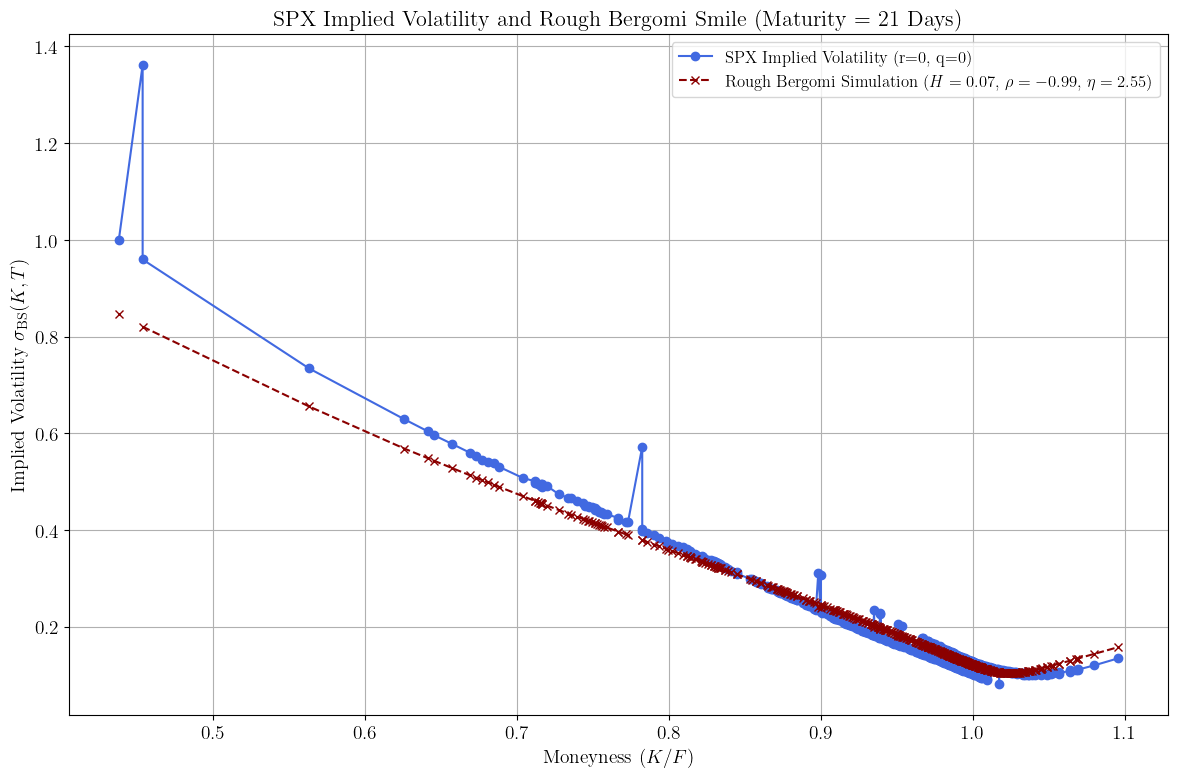

In [9]:
# --- Prepare Market Data for Plotting ---
#most_common_maturity = final_surface_df['time_to_maturity'].mode()[0]
T_market = most_common_maturity
smile_df_market = final_surface_df[final_surface_df['time_to_maturity'] == T_market].copy()
smile_df_market['moneyness'] = smile_df_market['strike'] / spot_price
smile_df_market = smile_df_market.sort_values(by='strike')

maturity_days = int(T_market * 365)
print(f"\nMarket data prepared for the most common maturity: {maturity_days} days (T={T_market:.4f} years).")
print(f"Spot: {spot_price:.2f}, Assumed r: {risk_free_rate}, Assumed q: {dividend_yield}")

# --- Final Calibrated Rough Bergomi Simulation Parameters ---
H_sim = 0.07
rho_sim = -0.99
eta_sim = 2.55
xi_sim = 0.022

n_steps_sim = int(252 * T_market)
n_paths_sim = 1000000  # Number of paths for the simulation

# --- Step 3.3: Run the Simulation ---
print("\n--- Starting Rough Bergomi Simulation ---")
start_time = time.time()

model = rBergomi(n_steps=n_steps_sim, T=T_market, H=H_sim)
S_paths = model.generate_paths(
    n_paths_sim, rho_sim, eta_sim, xi_sim, spot_price, risk_free_rate, dividend_yield
)
S_T = S_paths[:, -1] # Get terminal stock prices
print(f"Generated {n_paths_sim} paths in {time.time() - start_time:.2f} seconds.")

# --- Calculate Model's Implied Volatilities ---
model_vols = []
for index, row in smile_df_market.iterrows():
    K_market = row['strike']
    option_type_market = row['option_type'].lower()
    
    # Calculate Monte Carlo price based on simulated paths
    payoffs = np.maximum(S_T - K_market, 0) if option_type_market == 'c' else np.maximum(K_market - S_T, 0)
    model_price = np.mean(payoffs) # No discounting needed as r=0
    
    # Use the find_implied_vol function to back out the volatility
    iv = find_implied_vol(
        model_price, spot_price, K_market, T_market, risk_free_rate, dividend_yield, option_type_market
    )
    model_vols.append(iv)
    
plt.figure(figsize=(12, 8))

# Plot Market Data
plt.plot(smile_df_market['moneyness'], smile_df_market['implied_vol'], 'o-', 
         color='royalblue', label=r'SPX Implied Volatility (r=0, q=0)')

# Plot rBergomi Simulation Data
label_model = rf'Rough Bergomi Simulation ($H={H_sim}$, $\rho={rho_sim}$, $\eta={eta_sim}$)'
plt.plot(smile_df_market['moneyness'], model_vols, 'x--', 
         color='darkred', label=label_model)

# Titles and axis labels in LaTeX style (non-bold)
plt.title(rf'SPX Implied Volatility and Rough Bergomi Smile (Maturity = {maturity_days} Days)', fontsize=16)
plt.xlabel(r'Moneyness $(K/F)$', fontsize=14)
plt.ylabel(r'Implied Volatility $\sigma_{\mathrm{BS}}(K,T)$', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("SPX_vs_rough_bergomi_smile.png", dpi=600)
plt.show()
plt.close()

# Implied Volatility Smiles With Different Hurst Parameters

--- Starting Analysis for T = 0.5 Years ---
Starting simulation for H = 0.49...
Finished H = 0.49 in 7.06 seconds.
Starting simulation for H = 0.40...
Finished H = 0.40 in 6.87 seconds.
Starting simulation for H = 0.30...
Finished H = 0.30 in 7.40 seconds.
Starting simulation for H = 0.20...
Finished H = 0.20 in 7.38 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 7.42 seconds.
Plot saved as 'rbergomi_smiles_different_H_T0.5y.png'


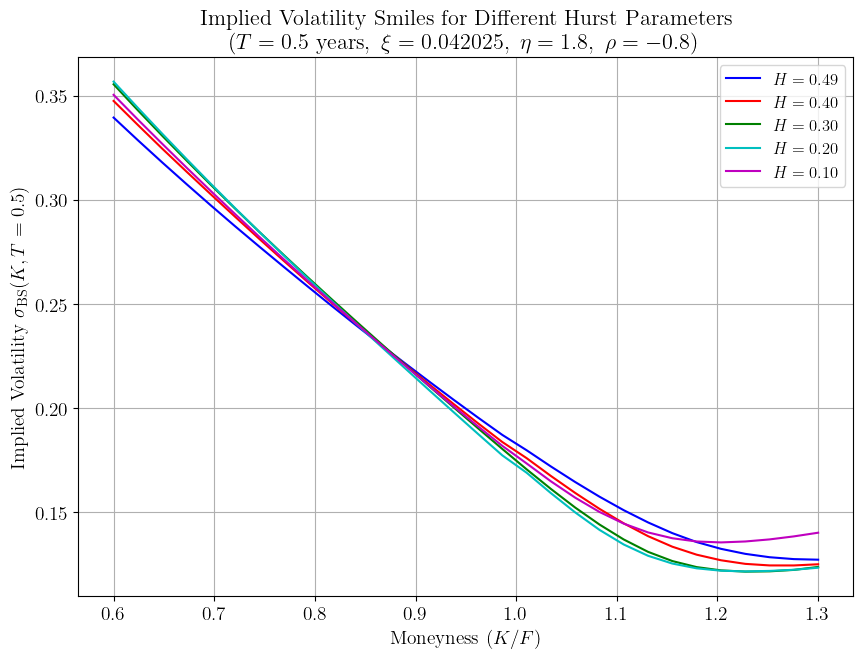

In [17]:
print("--- Starting Analysis for T = 0.5 Years ---")

# --- Parameters for T=0.5 ---
T_analysis_0_5 = 0.5
H_values = [0.49, 0.40, 0.30, 0.20, 0.10]
xi_fixed = 0.042025 # Average VIX value is around 20.50%. Variance would be the square of it 0.042025
eta_fixed = 1.8
rho_fixed = -0.8
S0_fixed = 1.0 
n_steps_0_5 = int(252 * T_analysis_0_5)
n_paths_analysis = 300000 
moneyness_range_0_5 = np.linspace(0.6, 1.3, 30)
colors = ['blue', 'red', 'green', 'c', 'm']
all_smiles_0_5 = {}

for H_val in H_values:
    all_smiles_0_5[H_val] = generate_smile(
        H=H_val, rho=rho_fixed, eta=eta_fixed, xi=xi_fixed, S0=S0_fixed,
        T=T_analysis_0_5, n_steps=n_steps_0_5, n_paths=n_paths_analysis,
        moneyness=moneyness_range_0_5
    )

plt.figure(figsize=(10, 7))
for i, H_val in enumerate(H_values):
    plt.plot(moneyness_range_0_5, all_smiles_0_5[H_val], label=rf'$H={H_val:.2f}$', color=colors[i])
title_text = (rf'Implied Volatility Smiles for Different Hurst Parameters' + '\n' +
              rf'$(T={T_analysis_0_5}\ \mathrm{{years}},\ \xi={xi_fixed},\ '
              rf'\eta={eta_fixed},\ \rho={rho_fixed})$')
plt.title(title_text)
plt.xlabel(r'Moneyness $(K/F)$', fontsize=14)
plt.ylabel(rf'Implied Volatility $\sigma_{{\mathrm{{BS}}}}(K, T={T_analysis_0_5})$', fontsize=14)
plt.grid(True)
plt.legend()

filename = f'rbergomi_smiles_different_H_T{T_analysis_0_5}y.png'
plt.savefig(filename, dpi=600)
print(f"Plot saved as '{filename}'")
plt.show()
plt.close()


--- Starting Analysis for T = 1.0 Years ---
Starting simulation for H = 0.49...
Finished H = 0.49 in 15.74 seconds.
Starting simulation for H = 0.40...
Finished H = 0.40 in 14.91 seconds.
Starting simulation for H = 0.30...
Finished H = 0.30 in 15.09 seconds.
Starting simulation for H = 0.20...
Finished H = 0.20 in 14.94 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 15.18 seconds.
Plot saved as 'rbergomi_smiles_different_H_T1.0y.png'


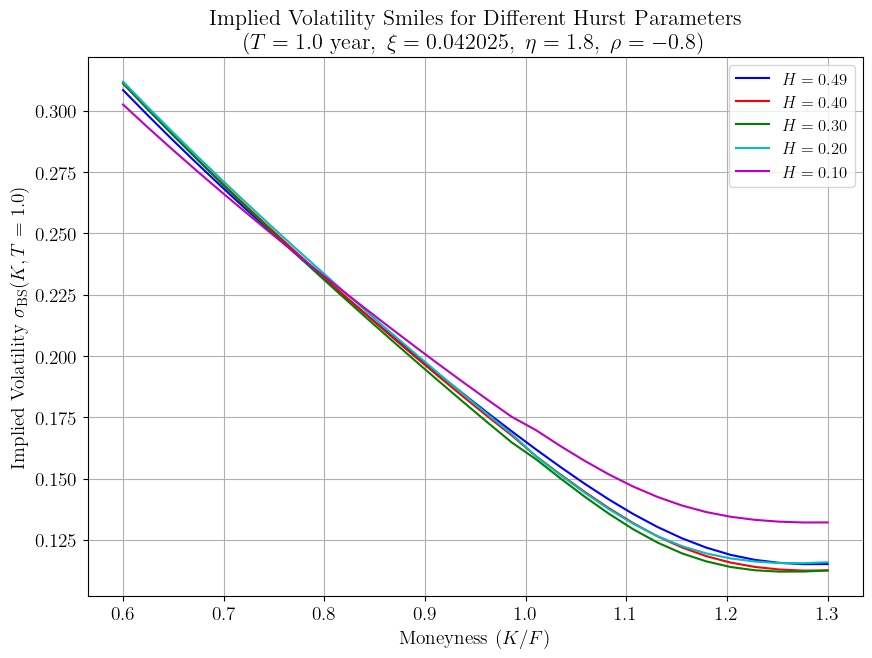

In [19]:
print("--- Starting Analysis for T = 1.0 Year ---")

# --- Parameters for T=1.0 Year ---
T_analysis_1_0 = 1.0
H_values = [0.49, 0.40, 0.30, 0.20, 0.10]
xi_fixed = 0.042025 # Average VIX value is around 20.50%. Variance would be the square of it 0.042025
eta_fixed = 1.8
rho_fixed = -0.8
S0_fixed = 1.0 
n_steps_1_0 = int(252 * T_analysis_1_0)
n_paths_analysis = 300000 
moneyness_range_1_0 = np.linspace(0.6, 1.3, 30)
colors = ['blue', 'red', 'green', 'c', 'm']
all_smiles_1_0 = {}

for H_val in H_values:
    all_smiles_1_0[H_val] = generate_smile(
        H=H_val, rho=rho_fixed, eta=eta_fixed, xi=xi_fixed, S0=S0_fixed,
        T=T_analysis_1_0, n_steps=n_steps_1_0, n_paths=n_paths_analysis,
        moneyness=moneyness_range_1_0
    )

plt.figure(figsize=(10, 7))
for i, H_val in enumerate(H_values):
    plt.plot(moneyness_range_1_0, all_smiles_1_0[H_val], label=rf'$H={H_val:.2f}$', color=colors[i])
title_text = (rf'Implied Volatility Smiles for Different Hurst Parameters' + '\n' +
              rf'$(T={T_analysis_1_0}\ \mathrm{{year}},\ \xi={xi_fixed},\ '
              rf'\eta={eta_fixed},\ \rho={rho_fixed})$')
plt.title(title_text)
plt.xlabel(r'Moneyness $(K/F)$', fontsize=14)
plt.ylabel(rf'Implied Volatility $\sigma_{{\mathrm{{BS}}}}(K, T={T_analysis_1_0})$', fontsize=14)
plt.grid(True)
plt.legend()

filename = f'rbergomi_smiles_different_H_T{T_analysis_1_0}y.png'
plt.savefig(filename, dpi=600)
print(f"Plot saved as '{filename}'")
plt.show()
plt.close()

--- Starting Analysis for T = 2.0 Years ---
Starting simulation for H = 0.49...
Finished H = 0.49 in 30.64 seconds.
Starting simulation for H = 0.40...
Finished H = 0.40 in 30.88 seconds.
Starting simulation for H = 0.30...
Finished H = 0.30 in 31.38 seconds.
Starting simulation for H = 0.20...
Finished H = 0.20 in 30.87 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 30.32 seconds.
Plot saved as 'rbergomi_smiles_different_H_T2.0y.png'


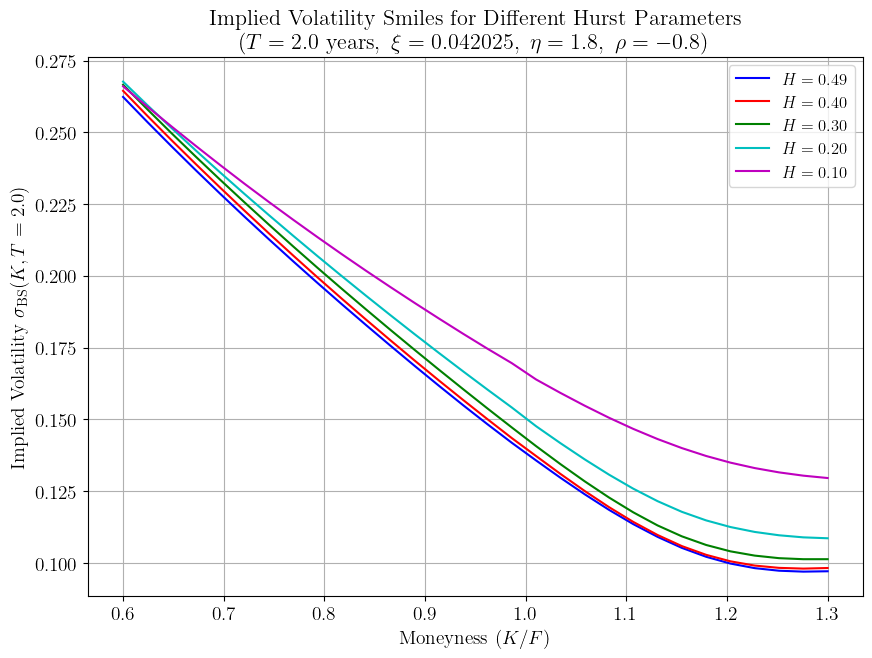

In [21]:
print("--- Starting Analysis for T = 2.0 Years ---")

# --- Parameters for T=2.0 ---
T_analysis_2_0 = 2.0
H_values = [0.49, 0.40, 0.30, 0.20, 0.10] 
xi_fixed = 0.042025 # Variance for a 20.50% VIX
eta_fixed = 1.8
rho_fixed = -0.8
S0_fixed = 1.0 
n_steps_2_0 = int(252 * T_analysis_2_0)
n_paths_analysis = 300000 
moneyness_range_2_0 = np.linspace(0.6, 1.3, 30)
colors = ['blue', 'red', 'green', 'c', 'm', 'black']
all_smiles_2_0 = {}

# --- Run Simulation for each H value ---
for H_val in H_values:
    all_smiles_2_0[H_val] = generate_smile(
        H=H_val, rho=rho_fixed, eta=eta_fixed, xi=xi_fixed, S0=S0_fixed,
        T=T_analysis_2_0, n_steps=n_steps_2_0, n_paths=n_paths_analysis,
        moneyness=moneyness_range_2_0
    )

# --- Plot the Results ---
plt.figure(figsize=(10, 7))
for i, H_val in enumerate(H_values):
    plt.plot(moneyness_range_2_0, all_smiles_2_0[H_val], label=rf'$H={H_val:.2f}$', color=colors[i])
title_text = (rf'Implied Volatility Smiles for Different Hurst Parameters' + '\n' +
              rf'$(T={T_analysis_2_0}\ \mathrm{{years}},\ \xi={xi_fixed},\ '
              rf'\eta={eta_fixed},\ \rho={rho_fixed})$')
plt.title(title_text)
plt.xlabel(r'Moneyness $(K/F)$', fontsize=14)
plt.ylabel(rf'Implied Volatility $\sigma_{{\mathrm{{BS}}}}(K, T={T_analysis_2_0})$', fontsize=14)
plt.grid(True)
plt.legend()

filename = f'rbergomi_smiles_different_H_T{T_analysis_2_0}y.png'
plt.savefig(filename, dpi=600)
print(f"Plot saved as '{filename}'")
plt.show()
plt.close()

--- Starting Analysis for T = 5.0 Years ---
Starting simulation for H = 0.49...
Finished H = 0.49 in 85.25 seconds.
Starting simulation for H = 0.40...
Finished H = 0.40 in 77.11 seconds.
Starting simulation for H = 0.30...
Finished H = 0.30 in 76.11 seconds.
Starting simulation for H = 0.20...
Finished H = 0.20 in 76.72 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 80.28 seconds.
Plot saved as 'rbergomi_smiles_different_H_T5.0y.png'


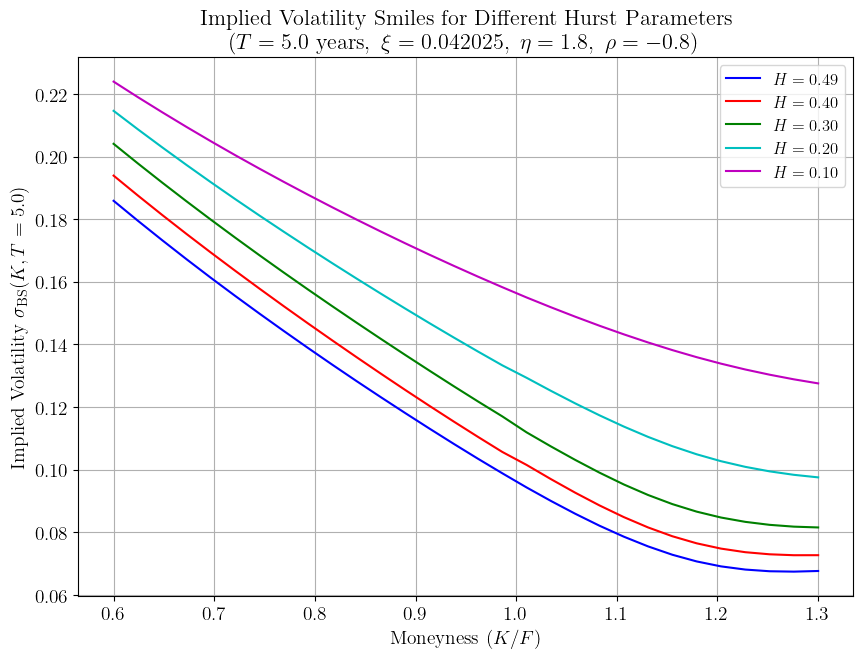

In [22]:
print("--- Starting Analysis for T = 5.0 Years ---")

# --- Parameters for T=5.0 ---
T_analysis_5_0 = 5.0
H_values = [0.49, 0.40, 0.30, 0.20, 0.10] 
xi_fixed = 0.042025 # Variance for a 20.50% VIX
eta_fixed = 1.8
rho_fixed = -0.8
S0_fixed = 1.0 
n_steps_5_0 = int(252 * T_analysis_5_0)
n_paths_analysis = 300000 
moneyness_range_5_0 = np.linspace(0.6, 1.3, 30)
colors = ['blue', 'red', 'green', 'c', 'm', 'black']
all_smiles_5_0 = {}

# --- Run Simulation for each H value ---
for H_val in H_values:
    all_smiles_5_0[H_val] = generate_smile(
        H=H_val, rho=rho_fixed, eta=eta_fixed, xi=xi_fixed, S0=S0_fixed,
        T=T_analysis_5_0, n_steps=n_steps_5_0, n_paths=n_paths_analysis,
        moneyness=moneyness_range_5_0
    )

# --- Plot the Results ---
plt.figure(figsize=(10, 7))
for i, H_val in enumerate(H_values):
    plt.plot(moneyness_range_5_0, all_smiles_5_0[H_val], label=rf'$H={H_val:.2f}$', color=colors[i])
title_text = (rf'Implied Volatility Smiles for Different Hurst Parameters' + '\n' +
              rf'$(T={T_analysis_5_0}\ \mathrm{{years}},\ \xi={xi_fixed},\ '
              rf'\eta={eta_fixed},\ \rho={rho_fixed})$')
plt.title(title_text)
plt.xlabel(r'Moneyness $(K/F)$', fontsize=14)
plt.ylabel(rf'Implied Volatility $\sigma_{{\mathrm{{BS}}}}(K, T={T_analysis_5_0})$', fontsize=14)
plt.grid(True)
plt.legend()

filename = f'rbergomi_smiles_different_H_T{T_analysis_5_0}y.png'
plt.savefig(filename, dpi=600)
print(f"Plot saved as '{filename}'")
plt.show()
plt.close()

## Term Structure of ATM Forward Skew for Different Hurst Parameters

--- Starting Analysis 1: Broader H Range ---

Calculating skew term structure for H = 0.05...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.05.

Calculating skew term structure for H = 0.10...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.10.

Calculating skew term structure for H = 0.20...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.20.

Calculating skew term structure for H = 0.30...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.30.

Calculating skew term structure for H = 0.40...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.40.

Total simulation time for Analysis 1: 229.30 minutes.


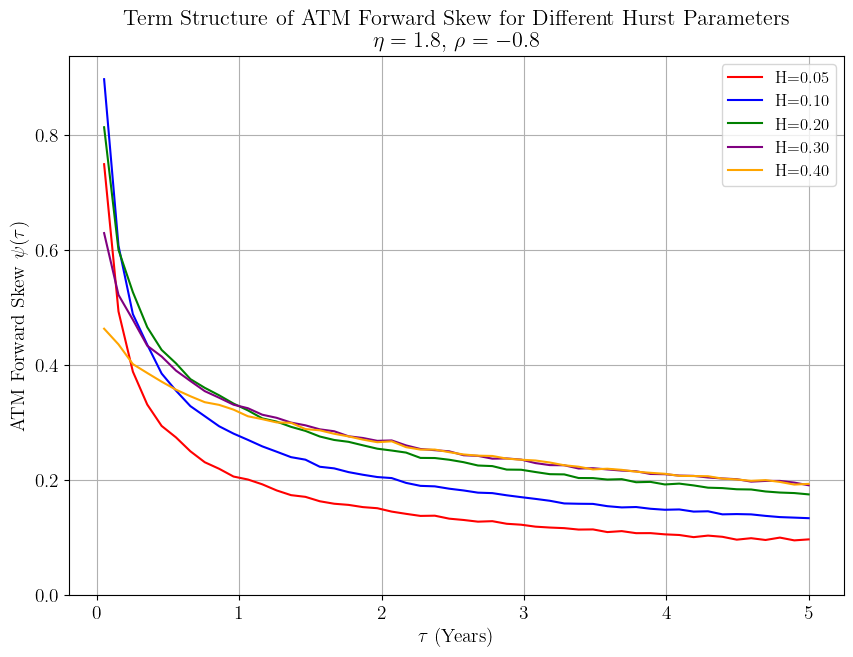

In [25]:
# --- Fixed Simulation Parameters ---
eta_fixed = 1.8
rho_fixed = -0.8
xi_fixed = 0.042025 
S0_fixed = 1.0
n_paths_skew_analysis = 300000
maturity_grid = np.linspace(0.05, 5, 50)

# --- Analysis 1: Broader Range of H ---
print("--- Starting Analysis 1: Broader H Range ---")
H_values_1 = [0.05, 0.1, 0.20, 0.30, 0.40]
colors_1 = ['red', 'blue', 'green', 'purple', 'orange']
all_skews_1 = {}
total_start_time_1 = time.time()

for H_val in H_values_1:
    all_skews_1[H_val] = calculate_atm_forward_skew_structure(
        H=H_val, rho=rho_fixed, eta=eta_fixed, xi=xi_fixed, S0=S0_fixed,
        maturity_grid=maturity_grid, n_paths_skew=n_paths_skew_analysis
    )
print(f"\nTotal simulation time for Analysis 1: {(time.time() - total_start_time_1)/60:.2f} minutes.")

# --- Plotting for Analysis 1 ---
plt.figure(figsize=(10, 7))
for i, H_val in enumerate(H_values_1):
    plt.plot(maturity_grid, all_skews_1[H_val], label=f'H={H_val:.2f}', color=colors_1[i])

title_text = f'Term Structure of ATM Forward Skew for Different Hurst Parameters\n$\\eta={eta_fixed}$, $\\rho={rho_fixed}$'
plt.title(title_text)
plt.xlabel('$\\tau$ (Years)')
plt.ylabel('ATM Forward Skew $\\psi(\\tau)$')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.savefig('atm_skew_H_05_40.png', dpi=600)
plt.show()
plt.close()


--- Starting Analysis 2: 'Rough' H Range ---

Calculating skew term structure for H = 0.02...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.02.

Calculating skew term structure for H = 0.04...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.04.

Calculating skew term structure for H = 0.06...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.06.

Calculating skew term structure for H = 0.08...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.08.

Calculating skew term structure for H = 0.10...
  -> Calculating maturity 50/50 (T=5.00 years)...
Calculation finished for H = 0.10.

Total simulation time for Analysis 2: 90.11 minutes.


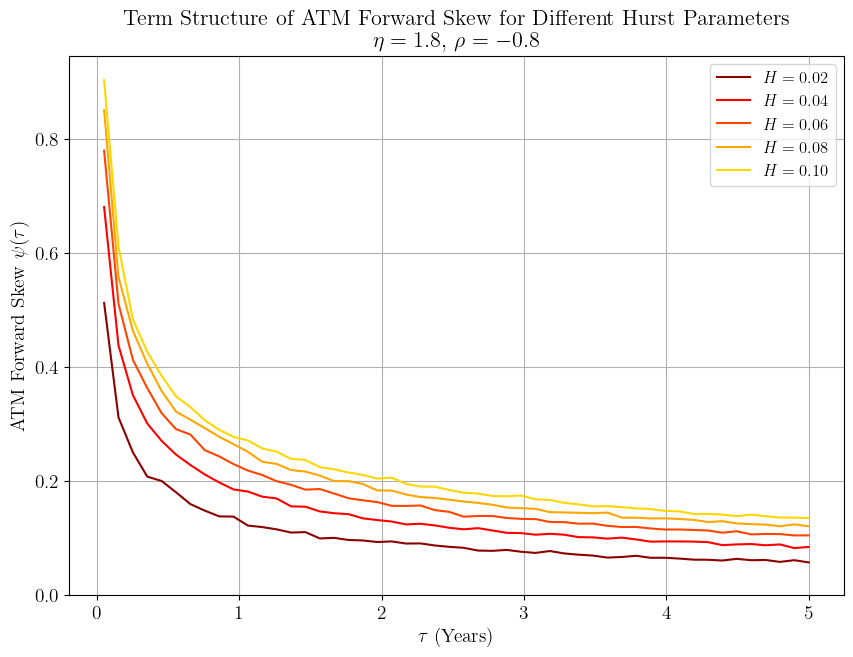

In [3]:
# --- Fixed Simulation Parameters (assumed to be the same) ---
eta_fixed = 1.8
rho_fixed = -0.8
xi_fixed = 0.042025 
S0_fixed = 1.0
n_paths_skew_analysis = 200000
maturity_grid = np.linspace(0.05, 5, 50)

# --- Analysis 2: "Rough" Regime of H ---
print("\n--- Starting Analysis 2: 'Rough' H Range ---")
H_values_2 = [0.02, 0.04, 0.06, 0.08, 0.10]
colors_2 = ['darkred', 'red', 'orangered', 'orange', 'gold']
all_skews_2 = {}
total_start_time_2 = time.time()

for H_val in H_values_2:
    all_skews_2[H_val] = calculate_atm_forward_skew_structure(
        H=H_val, rho=rho_fixed, eta=eta_fixed, xi=xi_fixed, S0=S0_fixed,
        maturity_grid=maturity_grid, n_paths_skew=n_paths_skew_analysis
    )
print(f"\nTotal simulation time for Analysis 2: {(time.time() - total_start_time_2)/60:.2f} minutes.")

plt.figure(figsize=(10, 7))
for i, H_val in enumerate(H_values_2):
    plt.plot(maturity_grid, all_skews_2[H_val], label=rf'$H={H_val:.2f}$', color=colors_2[i])


plt.title(r'Term Structure of ATM Forward Skew for Different Hurst Parameters' + '\n' + rf'$\eta={eta_fixed}$, $\rho={rho_fixed}$')
plt.xlabel(r'$\tau$ (Years)')
plt.ylabel(r'ATM Forward Skew $\psi(\tau)$')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.savefig('atm_skew_H_002_010.png', dpi=600)
plt.show()
plt.close()

## Comparison of Approximate Rough Bergomi ATM Forward Skew

Plot saved successfully as 'atm_skew_comparison_6_maturities_3x2.png'


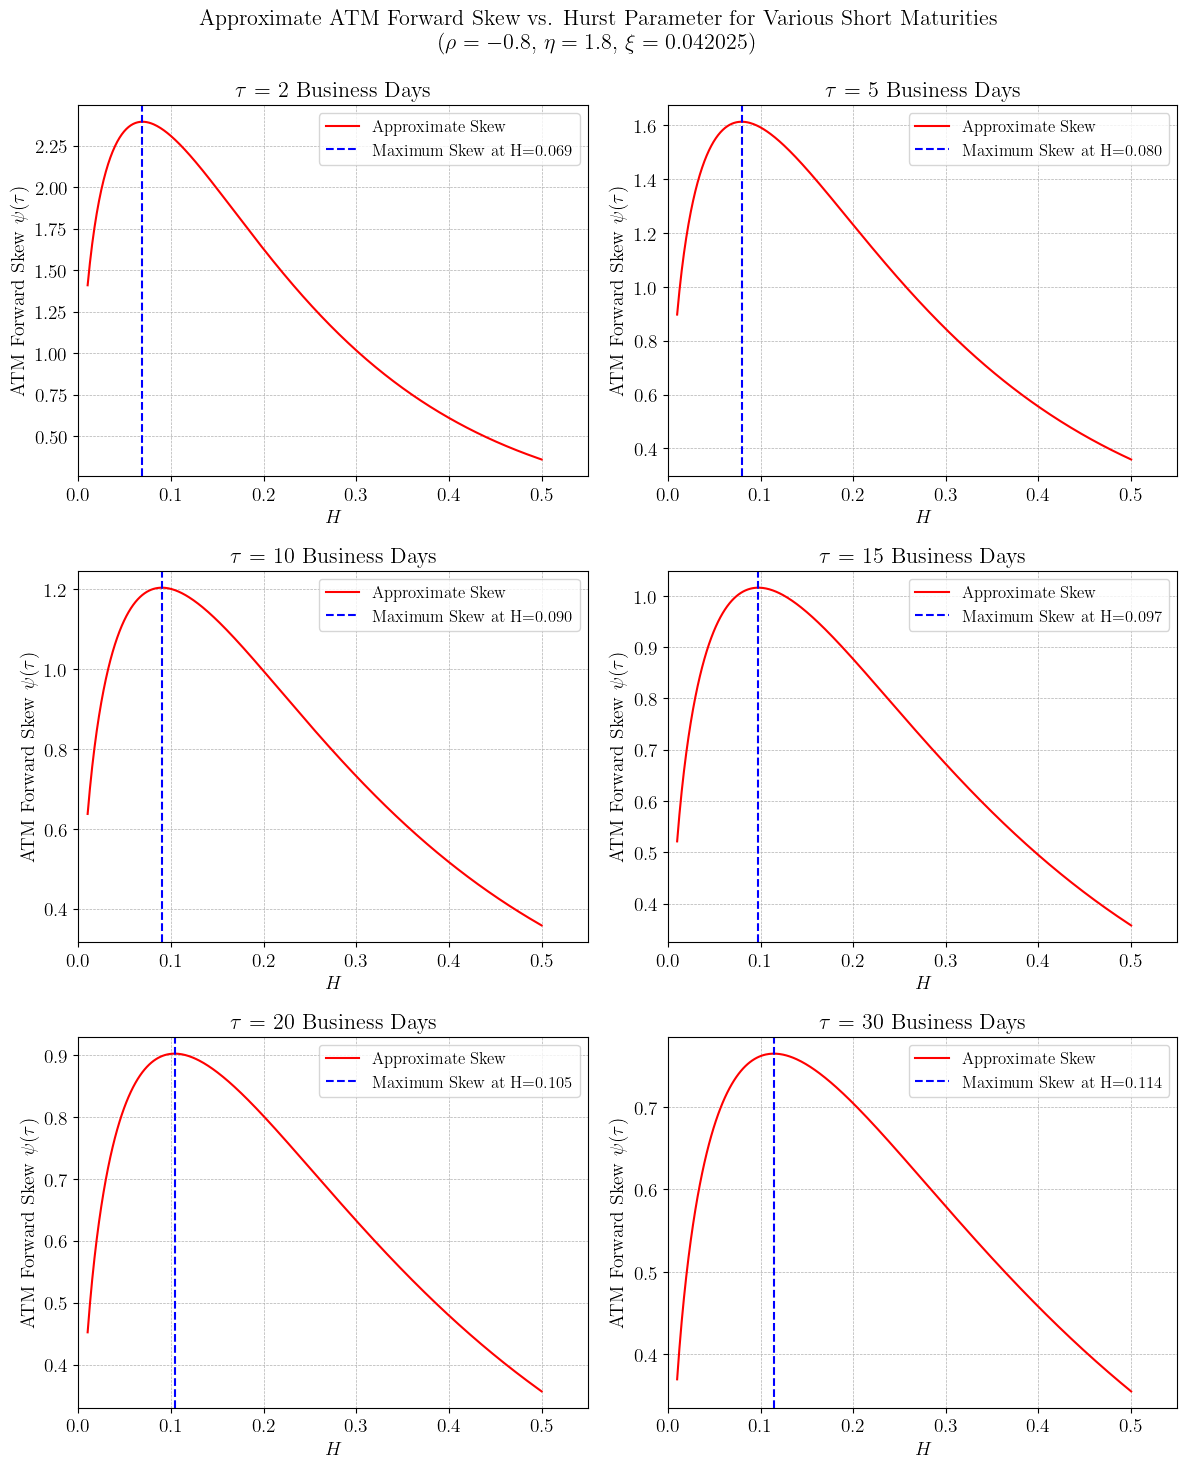

In [7]:
# --- Fixed Parameters for the Plots ---
rho_fixed = -0.8
eta_fixed = 1.8
xi_fixed = 0.042025  # Flat forward variance (sigma_bar^2)
sigma_bar_fixed = np.sqrt(xi_fixed)

# --- Variable Parameters ---
# Maturity (tau) values are given in business days.
tau_days = [2, 5, 10, 15, 20, 30]
trading_days_per_year = 252.0
tau_years = [day / trading_days_per_year for day in tau_days]

H_range = np.linspace(0.01, 0.5, 400)

fig, axes = plt.subplots(3, 2, figsize=(12, 15)) 
axes = axes.flatten() 

for i, tau_day in enumerate(tau_days):
    ax = axes[i]
    tau = tau_years[i]
    
    # Calculate the skew values for the current maturity.
    skew_values = np.abs(approximate_skew(H_range, tau, rho_fixed, eta_fixed, sigma_bar_fixed))
    
    # Find the H value that maximizes the skew.
    max_skew_index = np.nanargmax(skew_values)
    H_max = H_range[max_skew_index]
    
    ax.plot(H_range, skew_values, 'r-', label='Approximate Skew')
    
    # Show the H value at maximum skew with a vertical line.
    ax.axvline(x=H_max, color='b', linestyle='--', label=f'Maximum Skew at H={H_max:.3f}')
    
    # Set the axes and title for the subplot.
    ax.set_title(fr'$\tau$ = {int(tau_day)} Business Days')
    ax.set_xlabel(r'$H$')
    ax.set_ylabel(r'ATM Forward Skew $\psi(\tau)$')
    
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(0, 0.55)

# Main title and layout adjustment.
fig.suptitle(
    fr'Approximate ATM Forward Skew vs. Hurst Parameter for Various Short Maturities'
    '\n'
    fr'($\rho={rho_fixed}$, $\eta={eta_fixed}$, $\xi={xi_fixed}$)',
    fontsize=16
)

plt.tight_layout(rect=[0, 0, 1, 0.99]) # Prevent the main title from overlapping with subplots.

# Save the Figure
plt.savefig('atm_skew_comparison_6_maturities_3x2.png', dpi=600)
print("Plot saved successfully as 'atm_skew_comparison_6_maturities_3x2.png'")
plt.show()
plt.close()

## Implied Volatility Smiles for Different Rho and Eta

--- Generating Smiles for different rho ---
Starting simulation for H = 0.10...
Finished H = 0.10 in 39.44 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 41.30 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 40.95 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 40.24 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 42.29 seconds.

--- Generating Smiles for different eta ---
Starting simulation for H = 0.10...
Finished H = 0.10 in 43.84 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 41.44 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 39.92 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 39.25 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 41.95 seconds.
Plot saved successfully as 'rBergomi_rho_eta_smiles.png'


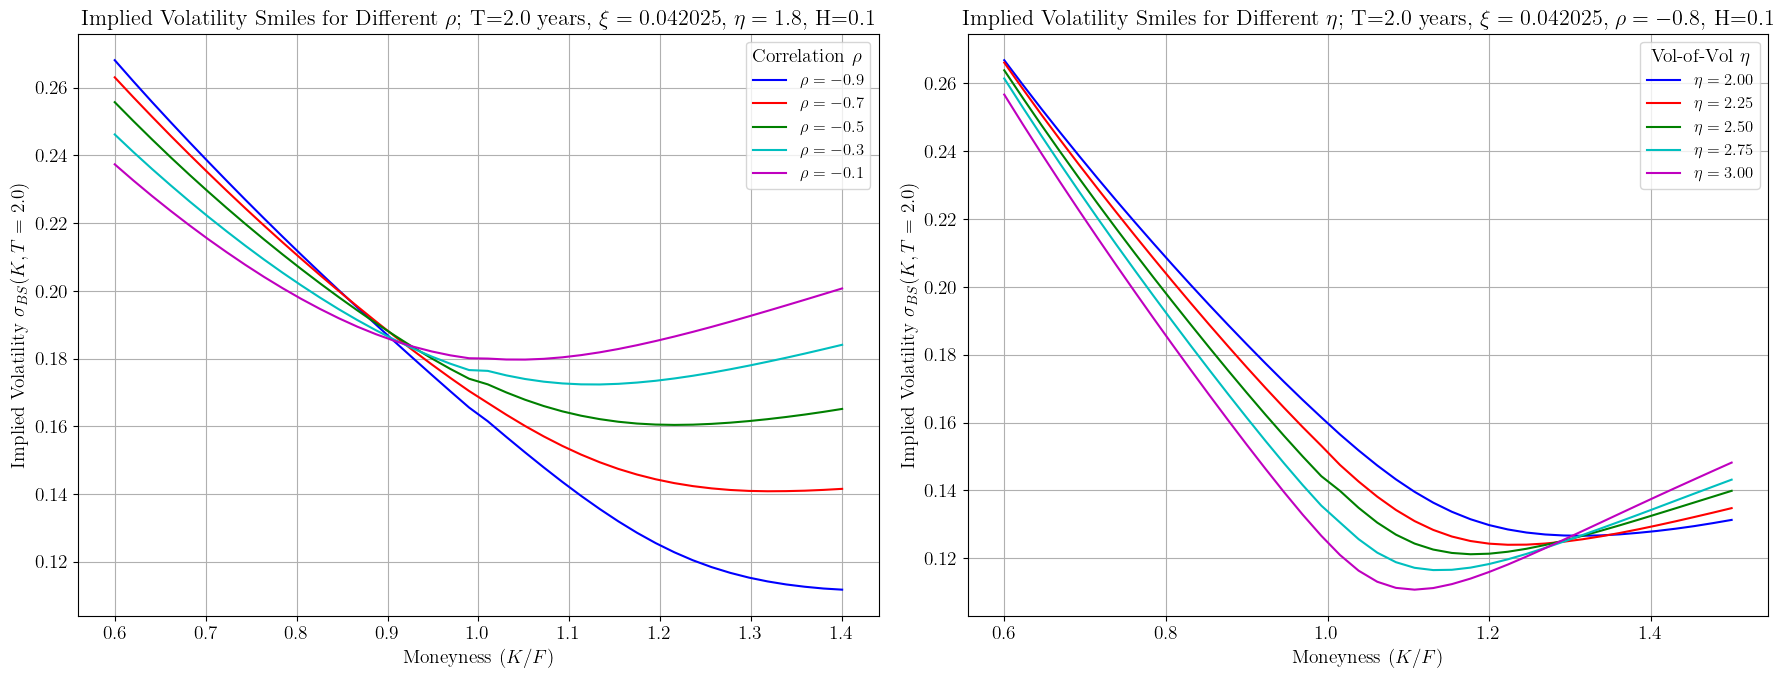

In [19]:
# These parameters are kept constant across both analyses to isolate the effects of rho and eta.
common_params = {
    'T': 2.0,          # Time to maturity in years
    'H': 0.1,          # Hurst parameter, controlling the "roughness" of volatility
    'xi': 0.042025,       # Initial forward variance (flat curve assumption)
    'S0': 1.0,         # Initial stock price, normalized to 1 for easy moneyness calculation
    'n_paths': 400000, # Number of Monte Carlo paths for simulation accuracy
}

# Create a figure with two subplots side-by-side (1 row, 2 columns) to hold both graphs.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Different rho ---
print("--- Generating Smiles for different rho ---")
ax1 = axes[0] # Select the first subplot
eta_fixed_a = 1.8
moneyness_range_a = np.linspace(0.6, 1.4, 40)
rho_values = [-0.9, -0.7, -0.5, -0.3, -0.1]
colors_a = ['b', 'r', 'g', 'c', 'm']

# Iterate through each specified rho value to generate a separate smile curve.
for i, rho_val in enumerate(rho_values):
    n_steps = int(252 * common_params['T']) # Daily steps
    
    # Call the simulation function with the current rho value and other fixed parameters.
    implied_vols = generate_smile(
        H=common_params['H'], rho=rho_val, eta=eta_fixed_a, xi=common_params['xi'], 
        S0=common_params['S0'], T=common_params['T'], n_steps=n_steps, 
        n_paths=common_params['n_paths'], moneyness=moneyness_range_a
    )
    # Plot the resulting implied volatility smile on the first subplot.
    ax1.plot(moneyness_range_a, implied_vols, label=f'$\\rho={rho_val:.1f}$', color=colors_a[i])

# Set the title and labels to match the thesis figure.
ax1.set_title(f"Implied Volatility Smiles for Different $\\rho$; T={common_params['T']} years, $\\xi={common_params['xi']}$, $\\eta={eta_fixed_a}$, H={common_params['H']}")
ax1.set_xlabel(r'Moneyness $(K/F)$', fontsize=14)
ax1.set_ylabel(f'Implied Volatility $\\sigma_{{BS}}(K, T={common_params["T"]})$')
ax1.legend(title=r'Correlation $\rho$')
ax1.grid(True)


# --- Plot (b): Different eta ---
# This block shows the effect of varying the volatility-of-volatility parameter eta.
# Eta primarily controls the curvature (smile) of the volatility surface.
print("\n--- Generating Smiles for different eta ---")
ax2 = axes[1] # Select the second subplot
rho_fixed_b = -0.8
moneyness_range_b = np.linspace(0.6, 1.5, 40)
eta_values = [2.0, 2.25, 2.5, 2.75, 3.0]
colors_b = ['b', 'r', 'g', 'c', 'm']

# Iterate through each specified eta value to generate a separate smile curve.
for i, eta_val in enumerate(eta_values):
    n_steps = int(252 * common_params['T'])
    
    # Call the simulation function with the current eta value and other fixed parameters.
    implied_vols = generate_smile(
        H=common_params['H'], rho=rho_fixed_b, eta=eta_val, xi=common_params['xi'], 
        S0=common_params['S0'], T=common_params['T'], n_steps=n_steps, 
        n_paths=common_params['n_paths'], moneyness=moneyness_range_b
    )
    ax2.plot(moneyness_range_b, implied_vols, label=f'$\\eta={eta_val:.2f}$', color=colors_b[i])


ax2.set_title(f"Implied Volatility Smiles for Different $\\eta$; T={common_params['T']} years, $\\xi={common_params['xi']}$, $\\rho={rho_fixed_b}$, H={common_params['H']}")
ax2.set_xlabel(r'Moneyness $(K/F)$', fontsize=14)
ax2.set_ylabel(f'Implied Volatility $\\sigma_{{BS}}(K, T={common_params["T"]})$')
ax2.legend(title=r'Vol-of-Vol $\eta$')
ax2.grid(True)

# Adjust layout to prevent titles from overlapping and show the final plot.
plt.tight_layout()
plt.savefig('rBergomi_rho_eta_smiles.png', dpi=600)
print("Plot saved successfully as 'rBergomi_rho_eta_smiles.png'")
plt.show()
plt.close()

Starting simulation for H = 0.10...
Finished H = 0.10 in 25.57 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 27.74 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 29.36 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 32.31 seconds.
Starting simulation for H = 0.10...
Finished H = 0.10 in 25.32 seconds.
Plot saved successfully as 'smiles_fixed_product.png'


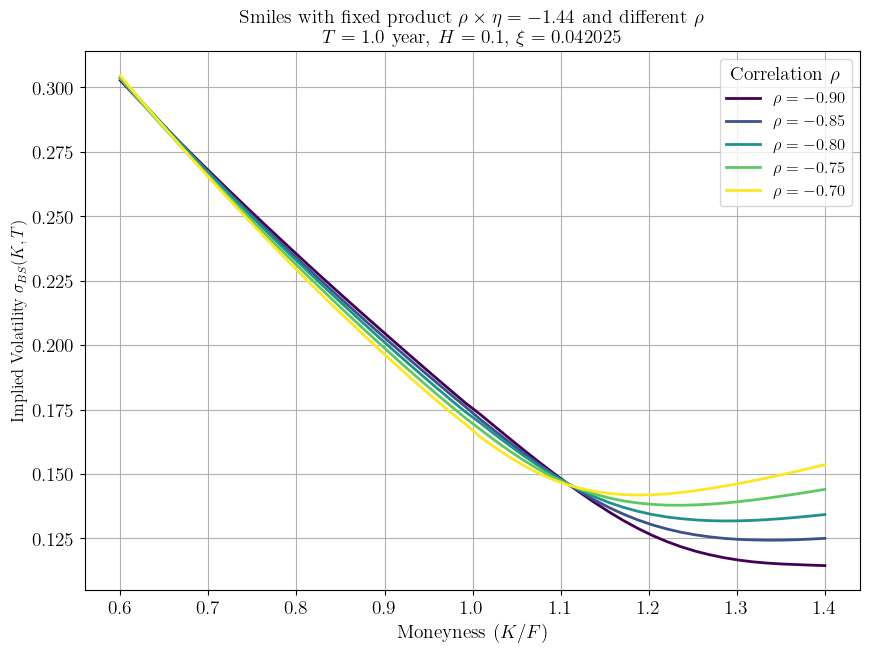

In [21]:
if __name__ == '__main__':
    # --- Parameters ---
    T_analysis = 1.0
    H_analysis = 0.1
    rho_eta_product = -1.44
    xi_analysis = 0.042025 
    S0_analysis = 1.0
    
    rho_values_to_test = [-0.90, -0.85, -0.80, -0.75, -0.70]

    # --- Simulation quality ---
    n_steps_analysis = int(252 * T_analysis)
    n_paths_analysis = 500000

    # --- Moneyness and Strikes ---
    # The moneyness range is set to be between 0.6 and 1.4.
    moneyness_range_k_f = np.linspace(0.6, 1.4, 50)

    # --- Simulation Loop ---
    all_smiles_analysis = {}
    for rho_val in rho_values_to_test:
        # Key constraint: rho * eta = -1.71
        eta_val = rho_eta_product / rho_val
        
        # Calling the 'generate_smile' function
        smile_data = generate_smile(
            H=H_analysis, rho=rho_val, eta=eta_val, xi=xi_analysis, S0=S0_analysis,
            T=T_analysis, n_steps=n_steps_analysis, n_paths=n_paths_analysis,
            moneyness=moneyness_range_k_f
        )
        all_smiles_analysis[rho_val] = smile_data

    # --- Plot Results ---
    plt.figure(figsize=(10, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(rho_values_to_test)))

    for i, rho_val in enumerate(rho_values_to_test):
        plt.plot(moneyness_range_k_f, all_smiles_analysis[rho_val], color=colors[i], lw=2, label=fr'$\rho={rho_val:.2f}$')

    title_text = (f'Smiles with fixed product $\\rho \\times \\eta = {rho_eta_product}$ and different $\\rho$\n'
                  fr'$T={T_analysis}$ year, $H={H_analysis}$, $\xi={xi_analysis}$')
    plt.title(title_text, fontsize=14)
    plt.xlabel(r'Moneyness $(K/F)$', fontsize=14)
    plt.ylabel(f'Implied Volatility $\\sigma_{{BS}}(K, T)$', fontsize=12)
    plt.legend(title=fr'Correlation $\rho$') 
    plt.grid(True)
    plt.savefig('smiles_fixed_product.png', dpi=600)
    print("Plot saved successfully as 'smiles_fixed_product.png'")
    plt.show()
    plt.close()